# Image Generation with AutoEncoders

In [1]:
from data import CelebADataset
from models import VAE, GAN
from keras.utils import plot_model
from tensorflow.keras.optimizers.legacy import Adam
from utils import plot_history
import tensorflow as tf

2024-05-24 16:05:21.138531: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 16:05:21.170580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 16:05:21.170609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 16:05:21.171514: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-24 16:05:21.176831: I tensorflow/core/platform/cpu_feature_guar

## Table of Contents

1. [Data preprocessing](#data-preprocessing)
2. [Baseline](#baseline)
    - [Variational AutoEncoder](#variational-autoencoder)
    - [WGAN-GP](#wgan-gp)

## Data preprocessing

We followed the CelebA dataset [official split](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to create a train (80%), validation (10%) and test (10%) subsets. In order to create the same split, the script [data.py](data.py) automatically prepares the dataset subfolders to load and train our models (it is required to previously download the [archive.zip](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) from Kaggle).

In [4]:
# !python3 data.py
train, val, test = map(CelebADataset, ('train', 'val', 'test'))

As detailed in the class notebooks, we used two types of normalization methods: in the Variational AutoEncoder (see [vae.py](models/vae.py)) the input images are scaled in the range $[0,1]$ (thus the final activation function is a sigmoid), while the GAN model accepts images in the range $[-1,1]$ and the generator module takes an hyperbolic tangent activation function. For these exercises, we used a resolution of $128\times 128$ to generate RGB images.


## Baseline 

### Variational AutoEncoder 

The Variational AutoEncoder ([Pu et al., 2016](https://proceedings.neurips.cc/paper/2016/file/eb86d510361fc23b59f18c1bc9802cc6-Paper.pdf)) is implemented in the script [vae.py](models/vae.py). The class `VAE` accepts the following hyperparameters:

- `img_size`: Image dimensions to feed the VAE. In this case, we used RGB images of dimension $128\times 128$.
- `hidden_size`: Dimension of the latent space. 
- `pool`: If `strides`, it uses doube-strides as a pooling method. If `dilation`, it uses a dilation rate of 2 followed by a max-pooling or up-sampling of factor 2.
- `residual`: Whether to use residual blocks.

The default configuration (used in class notebooks) uses a latent space of dimension $d_h = 200$ with double-strides and no residual nor skip connections:

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
vae = VAE(CelebADataset.IMG_SIZE, hidden_size=200, pool='strides', residual=False)

The `train()` method of the class `VAE` allows fitting the Keras model with the following hyperparameters:

- `train`: CelebA dataset instance with the training set.
- `val`: CelebA dataset instance with the validation set (used to track the losses and FID score).
- `test`: CelebA dataset instance with the evaluation set (used to save the final generated images).
- `path`: Folder to store all the training results.
- `batch_size`: Batch size.
- `epochs`: Number of training epochs. Default to 10.
- `train_patience`: Number of allowed epochs with no training improvement. Defaults to 5.
- `train_patience`: Number of allowed epochs with no training improvement. Defaults to 5.
- `val_patience`: Number of allowed epochs with no validation improvement. Defaults to 5.
- `steps_per_epoch`: Number of batches per epoch. Defaults to 1500.
- `optimizer`: Keras Optimizer. Defaults to Adam with learning rate $\eta=10^{-4}$.


In [4]:
vae_history = vae.train(train, val, test, 'results/vae/', optimizer=Adam(5e-4), epochs=10)

Found 162770 files belonging to 1 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7e247c0be680>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7e247c0be680>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Found 19867 files belonging to 1 classes.
Instructions for updating:
Colocations handled automatically by placer.


2024-05-24 15:37:59.295264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-05-24 15:37:59.295376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22324 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-05-24 15:37:59.474840: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-05-24 15:37:59.983429: W tensorflow/c/c_api.cc:305] Operation '{name:'batch_normalization_25/moving_mean/Assign' id:2142 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_25/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_25/

Train on 1500 steps, validate on 1500 steps
Epoch 1/10
1498/1500 [============================>.] - ETA: 0s - batch: 748.5000 - size: 1.0000 - loss: -93.7730 - r_loss: 0.0285 - kl_loss: -122.2272

/home/ana/Documents/dl-labs/P3/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-05-24 15:38:23.700127: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:582 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-24 15:38:28.623032: W tensorflow/c/c_api.cc:305] Operation '{name:'decoder/output/Sigmoid' id:492 op device:{requested: '', assigned: ''} def:{{{node decoder/output/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=t

1500/1500 [==============================] - 32s 20ms/step - batch: 749.5000 - size: 1.0000 - loss: -93.7872 - r_loss: 0.0284 - kl_loss: -122.2295 - val_loss: -104.1337 - val_r_loss: 0.0197 - val_kl_loss: -123.8619 - fid: 477.6633 - val_fid: 475.6469
Epoch 2/10
1499/1500 [============================>.] - ETA: 0s - batch: 749.0000 - size: 1.0000 - loss: -106.7144 - r_loss: 0.0172 - kl_loss: -123.9363

1500/1500 [==============================] - 27s 18ms/step - batch: 749.5000 - size: 1.0000 - loss: -106.7181 - r_loss: 0.0172 - kl_loss: -123.9365 - val_loss: -108.2951 - val_r_loss: 0.0158 - val_kl_loss: -124.0908 - fid: 476.1722 - val_fid: 474.1138
Epoch 3/10
1497/1500 [============================>.] - ETA: 0s - batch: 748.0000 - size: 1.0000 - loss: -108.9278 - r_loss: 0.0151 - kl_loss: -124.0710

1500/1500 [==============================] - 27s 18ms/step - batch: 749.5000 - size: 1.0000 - loss: -108.9337 - r_loss: 0.0151 - kl_loss: -124.0711 - val_loss: -110.2268 - val_r_loss: 0.0138 - val_kl_loss: -124.0612 - fid: 473.8613 - val_fid: 470.9565
Epoch 4/10
1498/1500 [============================>.] - ETA: 0s - batch: 748.5000 - size: 1.0000 - loss: -110.6693 - r_loss: 0.0133 - kl_loss: -124.0130

1500/1500 [==============================] - 27s 18ms/step - batch: 749.5000 - size: 1.0000 - loss: -110.6722 - r_loss: 0.0133 - kl_loss: -124.0131 - val_loss: -112.2341 - val_r_loss: 0.0118 - val_kl_loss: -124.0652 - fid: 490.3393 - val_fid: 489.8633
Epoch 5/10
1498/1500 [============================>.] - ETA: 0s - batch: 748.5000 - size: 1.0000 - loss: -112.5581 - r_loss: 0.0116 - kl_loss: -124.1391

1500/1500 [==============================] - 27s 18ms/step - batch: 749.5000 - size: 1.0000 - loss: -112.5584 - r_loss: 0.0116 - kl_loss: -124.1389 - val_loss: -112.7469 - val_r_loss: 0.0115 - val_kl_loss: -124.2486 - fid: 482.2096 - val_fid: 475.1132
Epoch 6/10
1496/1500 [============================>.] - ETA: 0s - batch: 747.5000 - size: 1.0000 - loss: -113.5147 - r_loss: 0.0107 - kl_loss: -124.2082

1500/1500 [==============================] - 27s 18ms/step - batch: 749.5000 - size: 1.0000 - loss: -113.5166 - r_loss: 0.0107 - kl_loss: -124.2083 - val_loss: -113.7057 - val_r_loss: 0.0105 - val_kl_loss: -124.2408 - fid: 479.5426 - val_fid: 475.8518
Epoch 7/10
1496/1500 [============================>.] - ETA: 0s - batch: 747.5000 - size: 1.0000 - loss: -114.1725 - r_loss: 0.0101 - kl_loss: -124.2513

1500/1500 [==============================] - 27s 18ms/step - batch: 749.5000 - size: 1.0000 - loss: -114.1762 - r_loss: 0.0101 - kl_loss: -124.2515 - val_loss: -114.6854 - val_r_loss: 0.0096 - val_kl_loss: -124.3290 - fid: 490.9765 - val_fid: 491.0800
Epoch 8/10
1492/1500 [============================>.] - ETA: 0s - batch: 745.5000 - size: 1.0000 - loss: -114.7818 - r_loss: 0.0095 - kl_loss: -124.3094

1500/1500 [==============================] - 27s 18ms/step - batch: 749.5000 - size: 1.0000 - loss: -114.7808 - r_loss: 0.0095 - kl_loss: -124.3095 - val_loss: -114.8396 - val_r_loss: 0.0095 - val_kl_loss: -124.2959 - fid: 480.6337 - val_fid: 478.4265
Epoch 9/10
1495/1500 [============================>.] - ETA: 0s - batch: 747.0000 - size: 1.0000 - loss: -115.1214 - r_loss: 0.0092 - kl_loss: -124.3381

1500/1500 [==============================] - 27s 18ms/step - batch: 749.5000 - size: 1.0000 - loss: -115.1211 - r_loss: 0.0092 - kl_loss: -124.3378 - val_loss: -114.4932 - val_r_loss: 0.0098 - val_kl_loss: -124.2660 - fid: 497.3051 - val_fid: 496.5571
Epoch 10/10
1499/1500 [============================>.] - ETA: 0s - batch: 749.0000 - size: 1.0000 - loss: -115.3596 - r_loss: 0.0090 - kl_loss: -124.3485

1500/1500 [==============================] - 27s 18ms/step - batch: 749.5000 - size: 1.0000 - loss: -115.3603 - r_loss: 0.0090 - kl_loss: -124.3485 - val_loss: -115.5226 - val_r_loss: 0.0089 - val_kl_loss: -124.3951 - fid: 486.4100 - val_fid: 481.9900


Once the training has ended, the folder used as the `path` variable will store the following elements:

```
results/
    vae/    
        model.weights.h5 
        history.pkl
        val-preds/
            ...
        test-preds/
            ...
```

- [model.weights.h5](results/vae/model.weights.h5): The best model weights in terms of FID score in the validation set.
- [history.pkl](results/vae/history.pkl): The training history (losses and metrics).
- [val-preds](results/vae/val-preds/): The generated images of the validation set during the training process (by default, 100 images are saved per epoch).
- [test-preds](results/vae/test-preds): The generated images of the test set at the end of the trainingprocess, with the best weight configuration.

The function `plot_history()` (see [utils.py](utils.py)) displays the progress of a given measure during the training stage.

In [6]:
plot_history(vae_history, 'loss').show()
plot_history(vae_history, 'kl_loss').show()
plot_history(vae_history, 'r_loss').show()
plot_history(vae_history, 'fid').show()

Finally, we can use the `display()` function (see [utils.py](utils.py)) to display the images generated by the VAE.

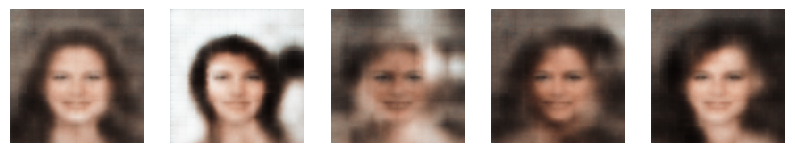

In [18]:
display(next(test.stream(vae.NORM, 5))[1], vae.model)

### WGAN-GP

Similarly, we used the implementation of the class notebooks to create a baseline with the WGAN-GP ([Arjovsky et al., 2017](https://arxiv.org/abs/1701.07875)). The class `GAN` (implemented in [gan.py](models/gan.py)) builds and trains the adversarial model with the specific callbacks and metrics. This class accepts the following arguments:

- `img_size`: Image size. For these exercises, we selected RGB images with resolution $128\times 128$.
- `hidden_size`: Dimension of the latent space.
- `pool`: Type of pooling ot use in the generator and discriminator. If `strides`, it uses convolutions with double-strides. If `dialtion` it uses dilated convolutions followed by max-pooling or up-sampling. By default `strides`.
- `residual`: Whether to use residual blocks. By default it uses standard convolutional blocks.
- `critic_steps`: Number of steps training the discriminator before optimizing the generator.
- `gp_weight`: Optimization hyperparameter in the gradient penalty.

In [5]:
wgan = GAN(CelebADataset.IMG_SIZE, hidden_size = 128, pool='strides', residual=False, critic_steps=3, gp_weight=10)

To train the GAN model the smae arguments as explained in the VAE implementation must be used:

In [6]:
wgan_history = wgan.train(train, val, test, path='results/wgan', batch_size=20, epochs=10)

In [ ]:
plot_history(wgan_history, name=['c_acc', 'g_acc']).update_xaxes(title_text='acc')